# CS110 Final Project 

# Deep Roots or Broad Roots?

Austin Perzben / Agustin Perez del Castillo  
Minerva Schools at KGI  
Fall 2019


--------------------------
## The Algorithm

#### Implementation

In [1]:
############################
##    Import Libraries    ##
############################

# !pip install big_o 

import networkx as nx # graph management and visualization library
from itertools import count # iteration method to track class instances
import string # ascii characters string manipulation library
from IPython.display import Image # display method for image files
from imageio import imread, mimsave # image file reading and writing methods
from os import remove as os_rm # system management method to remove local files
import random # pseudorandom operations library
import matplotlib.pyplot as plt # plot management and visualization library
import oneline as ol # my personal library for simple descriptive statistics (all functions run in one line!)
from time import time # timing library for runtime analysis
import big_o # asymptotic behavior estimation library

# ol.stats()


In [2]:
#############################
##    Real Silvics Data    ##
#############################

# real silvics for six species to use in the model simulations
silvics = {"Redwood":{'temp':(10,16), 'precip':(640,3100), 'soil':['sandy','leafy']},
           "Longleaf Pine":{'temp':(16,23), 'precip':(1090,1750), 'soil':['moist','dry','sandy','clay']},
           "Sugar Maple":{'temp':(-18,27), 'precip':(380,2030), 'soil':['leafy','sandy']},
           "Black Ash":{'temp':(-18,21), 'precip':(380,1140), 'soil':['snowy','sandy','clay']},
           "Sycamore":{'temp':(4,21), 'precip':(730,2030), 'soil':['moist','porous']},
           "Pin Oak":{'temp':(10,16), 'precip':(810,1270), 'soil':['clay','flat']}
          }

real_species = [] # variable to store all species names
soils = [] # variable to store all soil types
min_temp = float("inf") # initialize a minimum temperature tracker
max_temp = float("-inf") # initialize a maximum temperature tracker
min_precip = float("inf") # initialize a minimum precipitation tracker
max_precip = float("-inf") # initialize a maximum precipitation tracker

for each,val in silvics.items(): # iterate through each species in the real data
    real_species.append(each) # store the name in the list of species names
    for kind in val['soil']: # iterate through all the soil types for each species
        if kind not in soils: # check if each soil type was already added to the list of all soil types
            soils.append(kind) # if not, add it
    if min_temp > val['temp'][0]: # check if the minimum temperature is the lowest so far
        min_temp = val['temp'][0] # if so, update the tracker
    if max_temp < val['temp'][1]: # check if the maximum temperature is the highest so far
        max_temp = val['temp'][1] # if so, update the tracker
    if min_precip > val['precip'][0]: # check if the minimum precipitation is the lowest so far
        min_precip = val['precip'][0] # if so, update the tracker
    if max_precip < val['precip'][1]: # check if the maximum precipitation is the highest so far
        max_precip = val['precip'][1] # if so, update the tracker
    
temp_range = (min_temp, max_temp) # store the range of temperatures found from the real data
precip_range = (min_precip, max_precip) # store the range of precipitation levels from the real data

# print(real_species,'\n',soils,'\n',temp_range,'\n',precip_range) # print the reference values

In [3]:
##########################
##    Trees and Maps    ##
##########################

class Tree(object):
    """
    Tree class to generate and store each tree species as an object.
    """
    # initializer function to generate a tree object
    def __init__(self, species, name, temp, precip, soil):
        self.species = species # attribute to hold tree species
        self.name = name # attribute for the tree reference ID
        self.temp_range = temp # attribute for the tree's temperature range for growth
        self.precip_range = precip # attribute for the tree's precipitation range for growth
        self.soil_types = soil # attribute for the tree's natural soil types
        self.space = None # attribute to identify the tree's location(node) if and when planted
        self.happiness = 0.0 # attribute to keep track of best fit for the tree
    
    # method to plant a tree, assigning it to a node in a graph
    def plant_at(self, theMap, theSpace):
        self.space = theSpace
        theMap.G.add_node(theSpace, 
                          occupied = True,
                          tree = self.name) # update node attributes with the tree's information
        
    # method to evaluate the quality of match between the tree and a given space
    def match_score(self, theMap, theSpace):
        # calculate the temperature match score
        t1, t2 = self.temp_range, theMap.G.nodes[theSpace]['t_range']
        t_score = 10 - ol.mean([2*abs(t1[0]-t2[0])/10, 2*abs(t1[1]-t2[1])/10])
        # calculate the precipitation match score
        p1, p2 = self.precip_range, theMap.G.nodes[theSpace]['p_range']
        p_score = 10 - ol.mean([2*abs(p1[0]-p2[0])/1000, 2*abs(p1[1]-p2[1])/1000])
        # calculate the soil match score
        st_match = [2 for i in self.soil_types if i in theMap.G.nodes[theSpace]['s_types']]
        st_score = sum(st_match)*len(st_match)/len(soils)
        
        # combine into total score, adding a boolean term to account for whether the space is already occupied
        total = (t_score + p_score + st_score)*(not theMap.G.nodes[theSpace]['occupied'])
        
        # check if the total match score is significantly higher than the tree's current happiness
        if total - self.happiness > 0.2:
            self.plant_at(theMap, theSpace) # if so,
            self.happiness = round(total,3) # plant it and update its happiness attribute
            return self.name
            

class Map(object):
    """
    Graph Class to generate and store a map containing the spaces (nodes) available to plant.
    """
    # create a tracker for the animated output files for each method
    _ids = {'BFSgif':count(0),'DFSgif':count(0), 'BFSimg':count(0),'DFSimg':count(0),'':count(0)}
    
    # initializer method to generate a map object
    def __init__(self, n, edges):
        self.G = nx.Graph() # attribute for the virtual graph that models the map
        self.G.add_nodes_from(n) # populate the graph with the given number of spaces/nodes
        self.G.add_edges_from(edges) # add the given routes/edges to the graph
        self.pos = nx.spring_layout(self.G) # set the position of elements in the graph
    
    # method to display the map as a visualized graph
    def display(self, visited=None, covered=None, method=None, labels=None, to_gif=False):
        
        method = f'{method.upper()}img' if method != None else "" # handle the method input value
        
        plt.rcParams["figure.figsize"] = [14,6]
        plt.axis('off') # remove the plot axes
                
        if labels == None: # check if node labels were provided
            labels = {i:i for i in list(self.G.nodes())} # if not, use the spaces/nodes
        if visited == None: # check if a mask for visited spaces/nodes was provided
            visited = {i:False for i in list(self.G.nodes())} # if not, show all brown
        if covered == None: # check if a mask for covered routes/edges was provided
            covered = {i:False for i in list(self.G.edges())} # if not, show all brown
                
        nx.draw_networkx_nodes(self.G, self.pos, 
                               nodelist=[key for key,val in visited.items() if not val],
                               node_color='orange'
                              ) # draw non-visited spaces/nodes
        nx.draw_networkx_nodes(self.G, self.pos,
                               nodelist=[key for key,val in visited.items() if val],
                               node_color='green'
                              ) # draw visited spaces/nodes
        
        nx.draw_networkx_edges(self.G, self.pos, 
                               edgelist=[key for key,val in covered.items() if not val],
                               edge_color='brown',
                               width=1.0
                              ) # draw non-covered routes/edges
        nx.draw_networkx_edges(self.G, self.pos, 
                               edgelist=[key for key,val in covered.items() if val],
                               edge_color='green',
                               width=1.0
                              ) # draw covered routes/edges
        
        nx.draw_networkx_labels(self.G, self.pos, 
                                labels
                               ) # draw all labels
        
        # generate a unique file name for the image
        img_name = f'results/{method}_map{next(self._ids[method])}'
        # save the resulting image file
        plt.savefig(f'{img_name}.png')
        # make sure the plot window is closed to avoid overlap
        plt.close()
        # display the result if requested
        if not to_gif:
            display(Image(f'{img_name}.png'))
            
        return f'{img_name}.png'
        
    def gifify(self, v_list, c_list, method=None, labels=None):
                
        plt.axis('off') # remove the plot axes
        
        method = f'{method.upper()}gif' if method != None else "" # handle the method input value
        
        if labels == None: # check if node labels were provided
            labels = {i:i for i in list(self.G.nodes())} # if not, generate them using the names of the spaces/nodes
        
        num_steps = len(v_list) # store the number of steps to be animated
        
        if num_steps > 30: # check if the number of steps would cause a runtime error
            print("Woah! That's a lot of steps to animate! Try again with a simpler graph.")
            return # if so, return None and report the error to the user
        
        print(f'\nAnimating {method} Output...', end=" ") # notify the user that the animation is being generated
        
        self.filenames = [] # keep a list with the step filenames
        self.steps = [] # keep a list of the step image files
        
        for i in range(num_steps*4): # iterate through the number of frames, based on the number of steps
            # clear the existing plot
            plt.clf()
            # draw the plot at each step, divide by 4 to regulate fps
            step_name = self.display(v_list[i//4], c_list[i//4], to_gif=True)
            # store the name of each step's .png file
            self.filenames.append(step_name)
            # store each step .png file
            self.steps.append(imread(self.filenames[i]))
            # remove each .png file from memory, the .gif file only is stored
            os_rm(self.filenames[i])
        
        # generate a unique file name for each animation
        gif_name = f'results/{method}_map{next(self._ids[method])}'
        # generate and save the resulting .gif file
        mimsave(f'{gif_name}.gif', self.steps)
        # report the number of frames shown
        print(f'{num_steps*4} frames for {num_steps} steps')
        # display the animated result
        display(Image(f'{gif_name}.gif'))
        
        return f'{gif_name}.png'

In [26]:
################################
##    Simulation Functions    ##
################################

def generate_trees(n):
    
    sim_trees = {}
    tags = {i:count(0) for i in real_species}
    
    for sim in range(n):
        sp = random.choice(real_species)
        ID = f'{sp}-{next(tags[sp])}'
        temp = silvics[sp]['temp']
        prec = silvics[sp]['precip']
        soil = silvics[sp]['soil']
        
        sim_trees[ID] = Tree(sp, ID, temp, prec, soil)
        
    return sim_trees

def generate_map(numSpaces):
    
    nodes = [f'zone{i}' for i in range(numSpaces)]
    edges = [tuple(random.sample(nodes,2)) for i in range(random.randint( numSpaces,(numSpaces*(numSpaces-1//2))//2 ))]
    edges = list(set(edges))
    
    the_map = Map(nodes, edges)
    
    the_map.G.add_nodes_from(nodes,
                             occupied=False,
                             tree=None,
                             t_range=tuple(random.sample(range(min_temp, max_temp+1),2)),
                             p_range=tuple(random.sample(range(min_precip, max_precip+1),2)),
                             s_types=list(random.sample(soils,random.randint(1,4))))
        
    
    return the_map

In [27]:
################################
##    Breadth-First Search    ##
################################

def run_BFS(theMap, theTrees=None, s=None, animate=0, max_depth=float("inf")): 
    """
    Breadth-First Search Function.
    
    """
    if type(theMap) == tuple and theTrees == None:
        theMap,theTrees = theMap[0],theMap[1]
        
    # make sure the starting node has at least one neighbor and get one if not provided
    s = list(theMap.G.nodes())[0] if s == None else s
    if not list(theMap.G.adj[s]):
        for node in list(theMap.G.nodes()):
            if list(theMap.G.adj[node]):
                s = node
                break
    
    # create a depth tracker
    depth = {i:0 for i in theMap.G.nodes()}
    # create tracker of visited nodes
    visited = {i:False for i in theMap.G.nodes()}
    # create a tracker of covered edges
    covered = {i:False for i in theMap.G.edges()}
    
    if animate == 2: # check if function call requested gif output
        v_steps = [visited.copy()] # if so,
        c_steps = [covered.copy()] # create lists to store visited nodes and covered edges at each step
    
    # create a list to store the nodes to visit
    queue = []
    # queue the starting space/node
    queue.append(s)
    
    tag = count(1)
    # mark the starting space/node as visited
    visited[s] = next(tag)
    
    # iterate until all spaces/nodes are visited, or until the specified maximum depth is reached
    while queue:
        
        # print(f'\ncurrent:{queue[0]}') # uncomment to print the current space/node
        
        # remove the current node from the queue and store it as the source
        s = queue.pop(0)
        # print(f'Current:{s}')
        
        # check all trees and plant the one that matches best
        for ID, tree in theTrees.items():
            if tree.space == None:
                tree.match_score(theMap, s)
                # print(f'check to plant {ID} at {s}')
        
        # print(f'depth:{depth[s]}') # uncomment to print the relative depth of the current space/node
        
        if animate == 2: # check if function call requested animated output
            v_steps.append(visited.copy()) # if so,
            c_steps.append(covered.copy()) # keep track of each step
            
        for i in theMap.G.adj[s]: # iterate over all nodes adjacent to the current source
            
            rep = ((i,s), (s,i))[(s,i) in covered] # identify the representation given for each undirected route/edge
            if not covered[rep] and not(visited[i] and visited[s]): # check if the edge has been covered
                covered[rep] = True # if not, update the list of covered edges
            
            if not visited[i]: # check if each adjacent node has been visited
                # if not,
                depth[i] = depth[s] + 1 # update depth of each non-visited adjacent node
                if max(depth.values()) > max_depth: break; # terminate if maximum depth specified if reached
                
                queue.append(i) # queue each non-visited adjacent node
                visited[i] = next(tag) # update the list of visited nodes
                
                # print(f'cover{rep}') # uncomment to print each route/edge as it is covered
        
        # print(f'queue:{queue}') # uncomment to print the spaces/nodes queued to visit at each step
    
    if animate:
        # provide the output that the function call requested, either animated or not
        if animate == 1:
            theMap.display(visited, covered, 'bfs')
        elif animate == 2:
            theMap.gifify(v_steps, c_steps, 'bfs')
    
    planted_trees = {}
    
    for k in visited:
        tree = theMap.G.nodes[k]['tree']
        if tree == None:
            planted_trees['--No Tree--'] = [k, 'N/A']
        else:
            planted_trees[tree] = [k, theTrees[tree].happiness]
    
    t = '\n____________BFS TREES____________\t\n\n'
    space = [6 + len(max(list(planted_trees.keys()), key=lambda key: len(key))),
             6 + len(str(max(list(planted_trees.values())[0], key=lambda key: len(str(key)))))]
    
    for tree, vals in planted_trees.items():
        t += f'{str([tree]).ljust(space[0])}planted at {str([vals[0]]).ljust(space[1])}with happiness: {[vals[1]]}\n'

    # return the visited spaces/nodes and covered routes/edges, alongside the list of planted trees
    return {'table':t, 'path':visited, 'route':covered, 'trees':planted_trees}

In [28]:
##############################
##    Depth-First Search    ##
##############################

def run_DFS(theMap, theTrees=None, s=None, animate=0, max_depth=float("inf")):
    """
    Depth-First Search Function.
    
    """
    if type(theMap) == tuple and theTrees == None:
        theMap,theTrees = theMap[0],theMap[1]
        
    # make sure the starting node has at least one neighbor and get one if not provided
    s = list(theMap.G.nodes())[0] if s == None else s
    if not list(theMap.G.adj[s]):
        for node in list(theMap.G.nodes()):
            if list(theMap.G.adj[node]):
                s = node
                break
        
    depth = {i:0 for i in theMap.G.nodes()}
    visited = {i:False for i in theMap.G.nodes()}
    covered = {i:False for i in theMap.G.edges()}
    
    if animate == 2: # check if function call requested gif output
        v_steps = [visited.copy()] # if so,
        c_steps = [covered.copy()] # create lists to store visited nodes and covered edges at each step
    
    queue = [s]
    tag = count(1)
    
    while queue and False in visited.values():
        
        s = queue.pop()
        # print(f'\nCurrent:{[s]}')
        
        # check all trees and plant the one that matches best
        for ID, tree in theTrees.items():
            if tree.space == None:
                tree.match_score(theMap, s)
                # print(f'check to plant {ID} at {s}')
        
        if not visited[s]:
            
            visited[s] = next(tag)
            # print(f'\n{visited}\n{covered}\n')
            
            queue.extend([x for x in theMap.G.adj[s] if not visited[x]])
            for i in range(len(queue)-1,-1,-1):
                n = queue[i]
                if not visited[n]:
                    nxt,m = n,i
                    break
            queue = queue[:m+1]
            # print(f'queue:{queue}')
            # print(f'next:{[nxt]}')
            
            depth[nxt] = depth[s] + 1 # update depth of each non-visited adjacent node
            
            if max(depth.values()) > max_depth: break; # terminate if maximum depth specified if reached
            
            if animate == 2: # check if function call requested gif output
                v_steps.append(visited.copy()) # if so,
                c_steps.append(covered.copy()) # keep track of each step
        
        if (s,nxt) or (nxt,s) in covered:
            rep = ((s,nxt),(nxt,s))[(nxt,s) in covered]

        if rep not in covered:
            # print(f'catch:{[s]}->{[nxt]}')

            fb = max(visited, key=lambda key: visited[key] if key in list(theMap.G.adj[nxt]) else 0)
            # print(f'latest branch:{[fb]}')
            rep = ((fb,nxt),(nxt,fb))[(nxt,fb) in covered]            
            # print(f'fall back:{rep}')
        
        if not covered[rep]:
            # print(f'goto:{[nxt]}')
            covered[rep] = True
            
    if animate:
        # provide the output that the function call requested, either animated or not
        if animate == 1:
            theMap.display(visited, covered, 'dfs')
        elif animate == 2:
            theMap.gifify(v_steps, c_steps, 'dfs')
    
    planted_trees = {}
    
    for k in visited:
        tree = theMap.G.nodes[k]['tree']
        if tree == None:
            planted_trees['--No Tree--'] = [k, 'N/A']
        else:
            planted_trees[tree] = [k, theTrees[tree].happiness, ]
    
    t = '\n____________DFS TREES____________\t\n\n'
    space = [6 + len(max(list(planted_trees.keys()), key=lambda key: len(key))),
             6 + len(str(max(list(planted_trees.values())[0], key=lambda key: len(str(key)))))]
    
    for tree, vals in planted_trees.items():
        t += f'{str([tree]).ljust(space[0])} planted at {str([vals[0]]).ljust(space[1])} with happiness: {[vals[1]]}\n'
    # return the visited spaces/nodes and covered routes/edges, alongside the list of planted trees
    return {'table':t, 'path':visited, 'route':covered, 'trees':planted_trees}

In [69]:
#####################################
# Function to Reset Nodes and Trees #
#####################################

"""
IMPORTANT: Always call between search strategies if using the same model.

- The BFS and DFS functions both assign trees to spaces in the map, so the objects representing
  each planted tree and its space on the map will remain assigned after the function terminates.
  
- This function resets the model so no trees are planted and no spaces occupied.

"""

def reset_planted(Map, Trees=None,show=False):
    
    if type(Map) == tuple and Trees==None:
        Map,Trees = Map[0],Map[1]
        
    ns = list(Map.G.nodes())
    
    for k,v in Trees.items():
        v.happiness = 0.0
        v.space = None
    
    for n in Map.G.nodes():
        Map.G.node[n]['occupied'] = False
        Map.G.node[n]['tree'] = None
    
    check = [
        [[Map.G.node[n]['occupied'],Map.G.node[n]['tree']] for n in Map.G.nodes()],
        [[v.happiness, v.space] for _,v in Trees.items()]
    ]
    
    if show:
        blank = '-'*len(max(check, key=lambda key: len(str(check[0]))))
        print('Reset Nodes and Trees\n'.center(len(blank)*4)) # uncomment to see default values
        for n in range(max(len(check[0]),len(check[1]))):
            zone = str(ns[n]) if n < len(ns) else blank
            ocup = str(check[0][n]) if n < len(check[0]) else blank
            tree = str(check[1][n]) if n < len(check[1]) else blank
            print(f"{zone.center(len(blank)+3)} : {ocup.center(len(blank)+3)} | {tree.center(len(blank)+3)}")
            

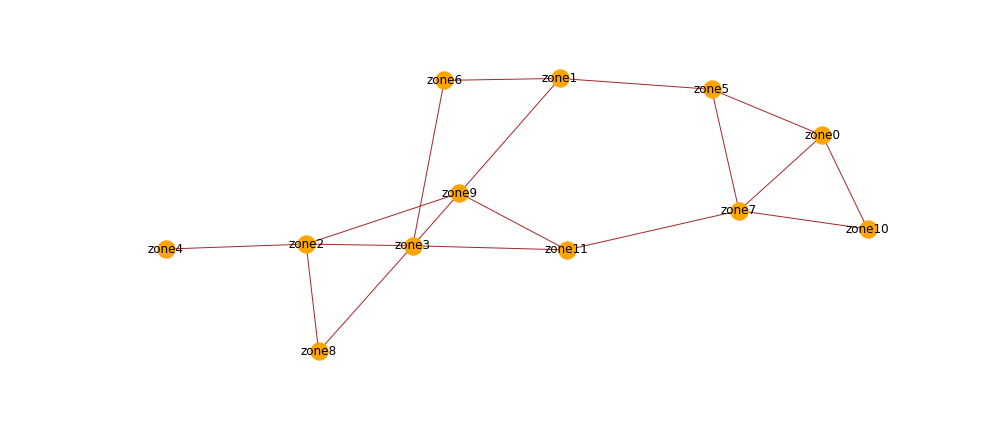

'results/_map293.png'

In [86]:
#################################
##  Build New Simulated Model  ##
#################################

num_nodes = 14
num_trees = 12

simTrees = generate_trees(num_nodes)
simMap = generate_map(num_trees)

simMap.display()
# for k,v in simTrees.items():
#     print(v.name)


Animating BFSgif Output... 52 frames for 13 steps


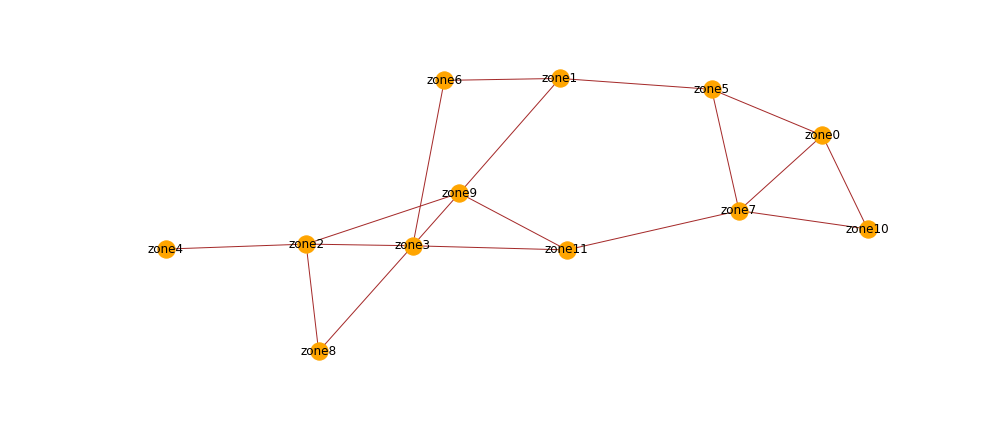


____________BFS TREES____________	

['Redwood-0']        planted at ['zone0']   with happiness: [17.381]
['Black Ash-0']      planted at ['zone1']   with happiness: [15.599]
['Redwood-2']        planted at ['zone2']   with happiness: [17.381]
['Pin Oak-1']        planted at ['zone3']   with happiness: [18.641]
['Sycamore-1']       planted at ['zone4']   with happiness: [17.261]
['Pin Oak-0']        planted at ['zone5']   with happiness: [18.641]
['Sugar Maple-0']    planted at ['zone6']   with happiness: [14.519]
['Longleaf Pine-1']  planted at ['zone7']   with happiness: [18.931]
['Sugar Maple-1']    planted at ['zone8']   with happiness: [14.519]
['Redwood-1']        planted at ['zone9']   with happiness: [17.381]
['Longleaf Pine-0']  planted at ['zone10']  with happiness: [18.931]
['Sycamore-0']       planted at ['zone11']  with happiness: [17.261]


Animating DFSgif Output... 52 frames for 13 steps


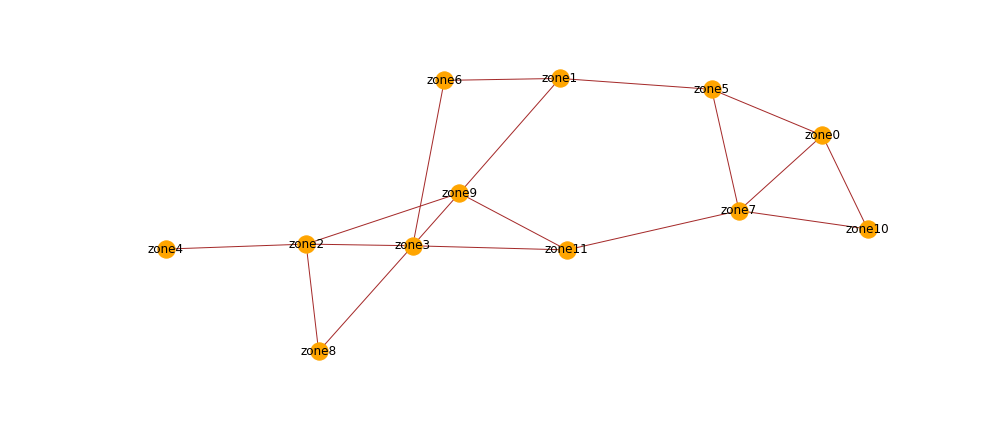


____________DFS TREES____________	

['Redwood-0']         planted at ['zone0']    with happiness: [17.381]
['Longleaf Pine-1']   planted at ['zone1']    with happiness: [18.931]
['Pin Oak-1']         planted at ['zone2']    with happiness: [18.641]
['Sycamore-0']        planted at ['zone3']    with happiness: [17.261]
['Sugar Maple-1']     planted at ['zone4']    with happiness: [14.519]
['Longleaf Pine-0']   planted at ['zone5']    with happiness: [18.931]
['Black Ash-0']       planted at ['zone6']    with happiness: [15.599]
['Pin Oak-0']         planted at ['zone7']    with happiness: [18.641]
['Redwood-2']         planted at ['zone8']    with happiness: [17.381]
['Redwood-1']         planted at ['zone9']    with happiness: [17.381]
['Sycamore-1']        planted at ['zone10']   with happiness: [17.261]
['Sugar Maple-0']     planted at ['zone11']   with happiness: [14.519]



In [87]:
##########################
##  Testing Playground  ##
##########################

# the root node for the search, optional, default: None (identifies the first node automatically)
root_node = 'zone0'
# the output style {0: no visual, 1: plot traversed map, 2: animated map traversal}, optional, default: 0
out_style = 2
# the maximum depth from the starting node to 
depth_lim = float("inf")

# Run BFS
BFS_out = run_BFS(simMap,simTrees,s=root_node,animate=out_style,max_depth=depth_lim)
print(BFS_out['table'])

# Reset Records
reset_planted(simMap, simTrees)

# Run DFS
DFS_out = run_DFS(simMap,simTrees,s=root_node,animate=out_style,max_depth=depth_lim)
print(DFS_out['table'])

In [48]:
############################
##    Runtime Analysis    ##
############################

def time_graph(x,t1,t2):
    plt.figure()
    plt.plot(x, t1, label = "BFS")
    plt.plot(x, t2, label = "DFS")
    plt.legend()
    plt.xlabel("Input Size")
    plt.ylabel("Time (sec)")
    plt.title("Running time")
    plt.show()
    return

In [49]:
N = 300

xlist = [i for i in range((N+1)//10, N+1, (N+1)//10)]
print(xlist)
GENtimes = []
BFStimes = []
DFStimes = []

print("Simulating [", end=" ")
for x in xlist:
    avg_GEN = []
    avg_BFS = []
    avg_DFS = []
    
    for i in range(5):
        
        GENstart = time()
        s_Map = generate_map(x)
        s_Trees = generate_trees(x)
        GENend = time()
        
        DFSstart = time()
        run_DFS(s_Map, s_Trees)
        DFSend = time()
        
        reset_planted(s_Map,s_Trees)
        
        BFSstart = time()
        run_BFS(s_Map, s_Trees)
        BFSend = time()
        
        avg_GEN.append(GENend - GENstart)
        avg_BFS.append(BFSend - BFSstart)
        avg_DFS.append(DFSend - DFSstart)
    
    GENtimes.append(ol.mean(avg_GEN))
    BFStimes.append(ol.mean(avg_BFS))
    DFStimes.append(ol.mean(avg_DFS))
    print("-", end=" ")
print("] Done!")

[30, 60, 90, 120, 150, 180, 210, 240, 270, 300]
Simulating [ - - - - - - - - - - ] Done!


0.7037056446075439 2.4845349311828615
0.7393181324005127 2.8662131309509276
0.9051014900207519 3.3801402091979984


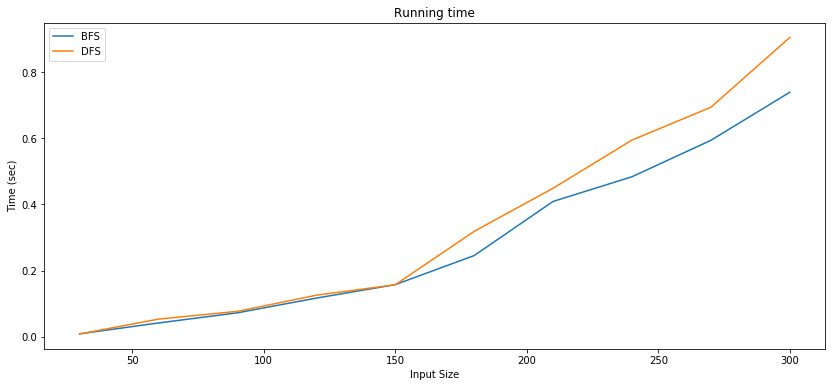

In [57]:
print(max(GENtimes),sum(GENtimes))
print(max(BFStimes),sum(BFStimes))
print(max(DFStimes),sum(DFStimes))

time_graph(xlist, BFStimes, DFStimes)

In [88]:
#################################
##  Big-O Empirical Estimates  ##
#################################

results = {'map':[],'trees':[],'bfs':[],'dfs':[],'res':[]}
strategy_datagen = lambda n: (generate_map(random.randint(4,n)), generate_trees(random.randint(4,n)))


In [89]:
results['map'].extend(big_o.big_o(generate_map,
                                  big_o.datagen.n_,
                                  n_repeats=20,
                                  min_n=10,
                                  max_n=300))

In [90]:
results['trees'].extend(big_o.big_o(generate_trees,
                                    big_o.datagen.n_,
                                    n_repeats=20,
                                    min_n=10,
                                    max_n=300))

In [91]:
results['bfs'].extend(big_o.big_o(run_BFS,
                                  strategy_datagen,
                                  n_repeats=100,
                                  min_n=4,
                                  max_n=200))

In [92]:
results['res'].extend(big_o.big_o(reset_planted,
                                 strategy_datagen,
                                 n_repeats=100,
                                 min_n=4,
                                 max_n=200))

In [93]:
results['dfs'].extend(big_o.big_o(run_DFS,
                                  strategy_datagen,
                                  n_repeats=100,
                                  min_n=4,
                                  max_n=200))

In [94]:
for key in results:
    print(f'{key}\n{results[key][0]}\n')
    for class_, residuals in results[key][1].items():
         print('{!s:<60s}    (res: {:.2G})'.format(class_, residuals))
    print('\n')

map
Exponential: time = -2.4 * 0.02^n (sec)

Constant: time = 5.9 (sec)                                      (res: 4.5E+02)
Linear: time = -4.3 + 0.066*n (sec)                             (res: 78)
Quadratic: time = -1.3 + 0.00022*n^2 (sec)                      (res: 20)
Cubic: time = 0.11 + 7.5E-07*n^3 (sec)                          (res: 13)
Polynomial: time = -7.7 * x^1.8 (sec)                           (res: 3.1)
Logarithmic: time = -16 + 4.7*log(n) (sec)                      (res: 2.4E+02)
Linearithmic: time = -3.4 + 0.011*n*log(n) (sec)                (res: 62)
Exponential: time = -2.4 * 0.02^n (sec)                         (res: 0.95)


trees
Linear: time = 0.0015 + 9E-05*n (sec)

Constant: time = 0.015 (sec)                                    (res: 0.00088)
Linear: time = 0.0015 + 9E-05*n (sec)                           (res: 0.00019)
Quadratic: time = 0.0064 + 2.8E-07*n^2 (sec)                    (res: 0.00021)
Cubic: time = 0.0084 + 9.2E-10*n^3 (sec)                        (r